In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from sklearn import preprocessing, metrics
import utils
import scipy.io
import numpy as np
from linear_classifier import LinearSVM_twoclass

# load the SPAM email training dataset

N_train = 3600

X,y = utils.load_mat('data/spamTrain.mat')
yy = np.ones(y.shape)
yy[y==0] = -1

X_train = X[:N_train] # <--- training data
yy_train = yy[:N_train] # <--- training label

X_val = X[N_train:] # <--- validation data
yy_val = yy[N_train:] # <--- validation label

# load the SPAM email test dataset

test_data = scipy.io.loadmat('data/spamTest.mat')
X_test = test_data['Xtest'] # <--- testing label
y_test = test_data['ytest'].flatten()

yy_test = np.ones(y_test.shape)
yy_test[y_test == 0] = -1 # <--- testing label



In [22]:
##################################################################################
#  YOUR CODE HERE for training the best performing SVM for the data above.       #
#  what should C be? What should num_iters be? Should X be scaled?               #
#  should X be kernelized? What should the learning rate be? What should the     #
#  number of iterations be?                                                      #
##################################################################################

sigma = 10.0
K = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
scaler = preprocessing.StandardScaler().fit(K)
scaleK = scaler.transform(K)
KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

Kval = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
# scalerval = preprocessing.StandardScaler().fit(Kval)
scaleKval = scaler.transform(Kval)
KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

Ktest = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_test for x2 in X_train]).reshape(X_test.shape[0],X_train.shape[0])
# scalertest = preprocessing.StandardScaler().fit(Ktest)
scaleKtest = scaler.transform(Ktest)
KKtest = np.vstack([np.ones((scaleKtest.shape[0],)),scaleKtest.T]).T


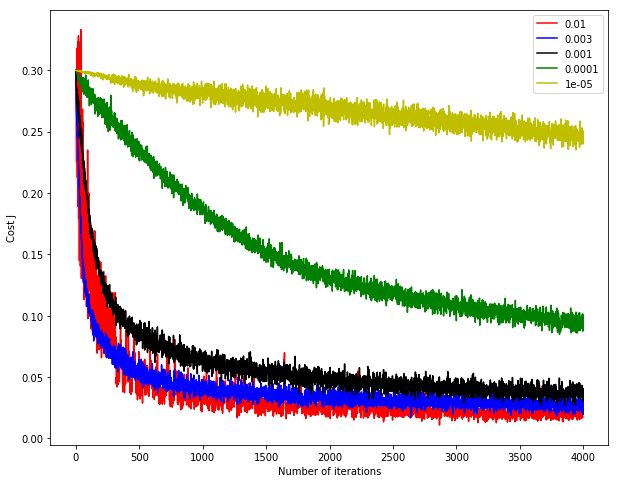

In [26]:
# choose learning rate
color = ['r','b','k','g','y','m']
LearningRatevals = [1e-2,3e-3,1e-3,1e-4,1e-5]
color_idx = 0
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for LR in LearningRatevals:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=LR,reg=0.3,num_iters=4000,verbose=False,batch_size=1000)
    plt.plot(range(len(J_history)), J_history, color[color_idx])
    color_idx += 1
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.legend([str(a) for a in LearningRatevals])
plt.show()
fig.savefig("./fig_learning_rate.pdf", format='pdf')

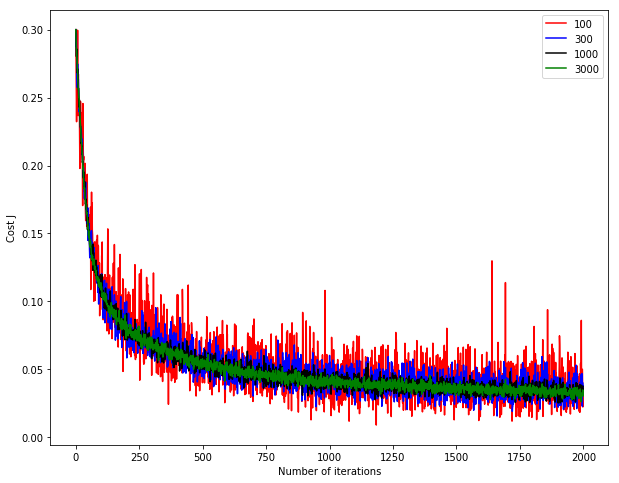

In [27]:
# choose batch size
Best_learning_rate = 3e-3
BatchSizes = [100,300,1000,3000]
color_idx = 0
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for BS in BatchSizes:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=0.3,num_iters=2000,verbose=False,batch_size=BS)
    plt.plot(range(len(J_history)), J_history, color[color_idx])
    color_idx += 1
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.legend([str(a) for a in BatchSizes])
plt.show()
fig.savefig("./fig_batch_size.pdf", format='pdf')

In [28]:
# choose C
Best_batch_size=3400
Cvals = [0.01,0.03,0.1,0.3,1,3,10,30,100]
for C in Cvals:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=C,num_iters=5000,verbose=False,batch_size=Best_batch_size)
    yy_pred_train = svm.predict(KK)
    accuracy_train = np.mean(yy_pred_train == yy_train)
    yy_pred_val = svm.predict(KKval)
    accuracy_val = np.mean(yy_pred_val == yy_val)
    print "C:\t", C, ", training accuracy:\t", accuracy_train, ", validation accuracy:\t", accuracy_val

C:	0.01 , training accuracy:	0.922222222222 , validation accuracy:	0.9325
C:	0.03 , training accuracy:	0.949722222222 , validation accuracy:	0.955
C:	0.1 , training accuracy:	0.963055555556 , validation accuracy:	0.9625
C:	0.3 , training accuracy:	0.969722222222 , validation accuracy:	0.97
C:	1 , training accuracy:	0.98 , validation accuracy:	0.9725
C:	3 , training accuracy:	0.986388888889 , validation accuracy:	0.9775
C:	10 , training accuracy:	0.989444444444 , validation accuracy:	0.9775
C:	30 , training accuracy:	0.990277777778 , validation accuracy:	0.9725
C:	100 , training accuracy:	0.990555555556 , validation accuracy:	0.975


In [29]:
# choose sigma
Best_C = 100.0
Sigmas = [1,3,10,30,100,300,1000]
for sigma in Sigmas:
    K = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
    scaler = preprocessing.StandardScaler().fit(K)
    scaleK = scaler.transform(K)
    KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

    Kval = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
#     scalerval = preprocessing.StandardScaler().fit(Kval)
    scaleKval = scaler.transform(Kval)
    KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

    Ktest = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_test for x2 in X_train]).reshape(X_test.shape[0],X_train.shape[0])
#     scalertest = preprocessing.StandardScaler().fit(Ktest)
    scaleKtest = scaler.transform(Ktest)
    KKtest = np.vstack([np.ones((scaleKtest.shape[0],)),scaleKtest.T]).T
    
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=Best_C,num_iters=2000,verbose=False,batch_size=Best_batch_size)
    yy_pred_train = svm.predict(KK)
    accuracy_train = np.mean(yy_pred_train == yy_train)
    yy_pred_val = svm.predict(KKval)
    accuracy_val = np.mean(yy_pred_val == yy_val)
    print "sigma:\t", sigma, ", training accuracy:\t", accuracy_train, ", validation accuracy:\t", accuracy_val

sigma:	1 , training accuracy:	1.0 , validation accuracy:	0.78
sigma:	3 , training accuracy:	0.998611111111 , validation accuracy:	0.9
sigma:	10 , training accuracy:	0.978333333333 , validation accuracy:	0.9725
sigma:	30 , training accuracy:	0.973611111111 , validation accuracy:	0.97
sigma:	100 , training accuracy:	0.884166666667 , validation accuracy:	0.89
sigma:	300 , training accuracy:	0.971666666667 , validation accuracy:	0.97
sigma:	1000 , training accuracy:	0.974444444444 , validation accuracy:	0.97


In [30]:
# choose iteration
Best_sigma = 10

K = np.array([utils.gaussian_kernel(x1,x2,Best_sigma) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
scaler = preprocessing.StandardScaler().fit(K)
scaleK = scaler.transform(K)
KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

Kval = np.array([utils.gaussian_kernel(x1,x2,Best_sigma) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
# scalerval = preprocessing.StandardScaler().fit(Kval)
scaleKval = scaler.transform(Kval)
KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

Iterations = [100,300,1000,3000,10000]
for iteration in Iterations:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=Best_C,num_iters=iteration,verbose=False,batch_size=Best_batch_size)
    yy_pred_train = svm.predict(KK)
    accuracy_train = np.mean(yy_pred_train == yy_train)
    yy_pred_val = svm.predict(KKval)
    accuracy_val = np.mean(yy_pred_val == yy_val)
    print "iteration:\t", iteration, ", training accuracy:\t", accuracy_train, ", validation accuracy:\t", accuracy_val

iteration:	100 , training accuracy:	0.719444444444 , validation accuracy:	0.68
iteration:	300 , training accuracy:	0.825833333333 , validation accuracy:	0.8175
iteration:	1000 , training accuracy:	0.971388888889 , validation accuracy:	0.9675
iteration:	3000 , training accuracy:	0.981388888889 , validation accuracy:	0.9775
iteration:	10000 , training accuracy:	0.993888888889 , validation accuracy:	0.9725


In [ ]:
Best_iteration = 10000
sigma_sweep = [3,6,10,20,30]
C_sweep = [30,60,100,200,300]
Best_val = -1
Best_C = None
Best_sigma = None

for sigma in sigma_sweep:
    K = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
    scaler = preprocessing.StandardScaler().fit(K)
    scaleK = scaler.transform(K)
    KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

    Kval = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
#     scalerval = preprocessing.StandardScaler().fit(Kval)
    scaleKval = scaler.transform(Kval)
    KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

    for C in C_sweep:
        svm = LinearSVM_twoclass()
        svm.theta = np.zeros((KK.shape[1],))
        J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=C,num_iters=Best_iteration,verbose=False,batch_size=Best_batch_size)
        yy_pred_train = svm.predict(KK)
        accuracy_train = np.mean(yy_pred_train == yy_train)
        yy_pred_val = svm.predict(KKval)
        accuracy_val = np.mean(yy_pred_val == yy_val)
        print "sigma:\t", sigma, ", C:\t", C, ", training accuracy:\t", accuracy_train, ", validation accuracy:\t", accuracy_val
        if accuracy_val > Best_val:
            Best_val = accuracy_val
            Best_C = C
            Best_sigma = sigma
print "Best:\t", Best_val, Best_C, Best_sigma

sigma:	3 , C:	30 , training accuracy:	1.0 , validation accuracy:	0.9025
sigma:	3 , C:	60 , training accuracy:	1.0 , validation accuracy:	0.9125


In [32]:
Best_C = None
Best_sigma = None
Best_accuracy = 0.0

# svm = LinearSVM_twoclass()
# svm.theta = np.zeros((X.shape[1],))


##################################################################################
# YOUR CODE HERE for testing your best model's performance                       #
# what is the accuracy of your best model on the test set? On the training set?  #
##################################################################################



##################################################################################
# ANALYSIS OF MODEL: Print the top 15 words that are predictive of spam and for  #
# ham. Hint: use the coefficient values of the learned model                     #
##################################################################################
words, inv_words = utils.get_vocab_dict()

##################################################################################
#                    END OF YOUR CODE                                            #
##################################################################################